In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from random import choice
import os
import optuna
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer , KNNImputer
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import OneHotEncoder , LabelEncoder , StandardScaler , RobustScaler , FunctionTransformer
from sklearn.model_selection import cross_validate , cross_val_score , StratifiedKFold , train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier , AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score , precision_score , recall_score , classification_report , f1_score

c:\Users\rider\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
os.chdir(path="c:\\Users\\rider\\Downloads")

In [13]:
# read datasef
df = pd.read_csv('zomato.csv')

In [15]:
#make data summary

def summary_data(dataframe) :

  summary = pd.DataFrame(dataframe.dtypes , columns=['Dtypes'])
  summary['Missing %'] = dataframe.isna().mean() * 100
  summary['Count'] = dataframe.count().values
  summary['Unique'] = dataframe.nunique().values


  return summary


summary_data(df).style.background_gradient(cmap='Blues')



,Dtypes,Missing %,Count,Unique
url,object,0.000000,51717,51717
address,object,0.000000,51717,11495
name,object,0.000000,51717,8792
online_order,object,0.000000,51717,2
book_table,object,0.000000,51717,2
rate,object,15.033741,43942,64
votes,int64,0.000000,51717,2328
phone,object,2.335789,50509,14926
location,object,0.040606,51696,93
rest_type,object,0.438927,51490,93


the target column has 15% missing values , i ll try two trials , first is to remove them and train , second to impute them and train

# First Trial - Remove nulls

In [19]:
df['rate'].unique()

array(['4.1/5', '3.8/5', '3.7/5', '3.6/5', '4.6/5', '4.0/5', '4.2/5',
       '3.9/5', '3.1/5', '3.0/5', '3.2/5', '3.3/5', '2.8/5', '4.4/5',
       '4.3/5', 'NEW', '2.9/5', '3.5/5', '2.6/5', '3.8 /5', '3.4/5',
       '4.5/5', '2.5/5', '2.7/5', '4.7/5', '2.4/5', '2.2/5', '2.3/5',
       '3.4 /5', '-', '3.6 /5', '4.8/5', '3.9 /5', '4.2 /5', '4.0 /5',
       '4.1 /5', '3.7 /5', '3.1 /5', '2.9 /5', '3.3 /5', '2.8 /5',
       '3.5 /5', '2.7 /5', '2.5 /5', '3.2 /5', '2.6 /5', '4.5 /5',
       '4.3 /5', '4.4 /5', '4.9/5', '2.1/5', '2.0/5', '1.8/5', '4.6 /5',
       '4.9 /5', '3.0 /5', '4.8 /5', '2.3 /5', '4.7 /5', '2.4 /5',
       '2.1 /5', '2.2 /5', '2.0 /5', '1.8 /5'], dtype=object)

In [20]:
def fix_rate(input_rate) :
    if isinstance(input_rate,str) :
        if '/' in input_rate :
            return float(input_rate.split('/')[0].strip())
        else:
            return np.nan
    return np.nan

df['rate'] = df['rate'].apply(fix_rate)

In [21]:
df.dropna(subset=['rate'] , inplace=True)
df.reset_index(drop=True , inplace=True)
summary_data(df).style.background_gradient(cmap='Blues')

,Dtypes,Missing %,Count,Unique
url,object,0.000000,41665,41665
address,object,0.000000,41665,8855
name,object,0.000000,41665,6649
online_order,object,0.000000,41665,2
book_table,object,0.000000,41665,2
rate,float64,0.000000,41665,31
votes,int64,0.000000,41665,2325
phone,object,1.953678,40851,12198
location,object,0.000000,41665,92
rest_type,object,0.357614,41516,87


In [22]:
def fix_cost(input_cost):
    if isinstance(input_cost,str) :
        return int(input_cost.replace(',',''))
    return input_cost

df['approx_cost(for two people)'] = df['approx_cost(for two people)'].apply(fix_cost)

In [23]:
df['approx_cost(for two people)'].unique()

array([ 800.,  300.,  600.,  700.,  550.,  500.,  450.,  650.,  400.,
        900.,  200.,  750.,  150.,  850.,  100., 1200.,  350.,  250.,
        950., 1000., 1500., 1300.,  199., 1100., 1600.,  230.,  130.,
       1700., 1350., 2200., 1400., 2000., 1800.,   nan, 1900.,  180.,
        330., 2500., 2100., 3000., 2800., 3400.,   50.,   40., 1250.,
       3500., 4000., 2400., 2600., 1450.,   70., 3200.,  240., 6000.,
       1050., 2300., 4100.,  120., 5000., 3700., 1650., 2700., 4500.,
         80.])

In [24]:
knn = KNNImputer(n_neighbors=3)
df['approx_cost(for two people)'] = knn.fit_transform(df[['approx_cost(for two people)']])

In [25]:
df.drop(['url','address','name','phone','dish_liked','reviews_list','menu_item','listed_in(type)','listed_in(city)','cuisines'],axis=1,inplace=True)

In [26]:
df['rate'] = df['rate'].apply(lambda x : 1 if x >= 3.7 else 0)

In [27]:
location_list = df['location'].value_counts().reset_index()['location'].to_list()[:25]
rest_type_list = df['rest_type'].value_counts().reset_index()['rest_type'].to_list()[:10]
df['location'] = df['location'].apply(lambda x : x if x in location_list else 'Other')
df['rest_type'] = df['rest_type'].apply(lambda x : x if x in rest_type_list else 'Other')

In [28]:
df

,online_order,book_table,rate,votes,location,rest_type,approx_cost(for two people)
0,Yes,Yes,1,775,Banashankari,Casual Dining,800.0
1,Yes,No,1,787,Banashankari,Casual Dining,800.0
2,Yes,No,1,918,Banashankari,Other,800.0
3,No,No,1,88,Banashankari,Quick Bites,300.0
4,No,No,1,166,Basavanagudi,Casual Dining,600.0
...,...,...,...,...,...,...,...
41660,No,No,1,34,Whitefield,"Casual Dining, Bar",800.0
41661,No,No,0,81,Whitefield,"Casual Dining, Bar",800.0
41662,No,No,0,27,Whitefield,Bar,1500.0
41663,No,Yes,1,236,Other,Bar,2500.0


In [31]:
df['rest_type'].fillna(df['rest_type'].mode().iloc[0] , inplace=True)
df['location'].fillna(df['location'].mode().iloc[0] , inplace=True)

In [32]:
ohe = OneHotEncoder(sparse_output=False , drop='first')
ohe_df = pd.DataFrame(ohe.fit_transform(df[['online_order' , 'book_table' , 'location' , 'rest_type']]),columns=ohe.get_feature_names_out())
ohe_df

,online_order_Yes,book_table_Yes,location_Banashankari,location_Bannerghatta Road,location_Basavanagudi,location_Bellandur,location_Brigade Road,location_Electronic City,location_HSR,location_Indiranagar,...,rest_type_Bar,rest_type_Beverage Shop,rest_type_Cafe,rest_type_Casual Dining,"rest_type_Casual Dining, Bar",rest_type_Delivery,rest_type_Dessert Parlor,rest_type_Other,rest_type_Quick Bites,"rest_type_Takeaway, Delivery"
0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41660,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
41661,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
41662,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41663,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
df = pd.concat([df , ohe_df] , axis=1)
df

,online_order,book_table,rate,votes,location,rest_type,approx_cost(for two people),online_order_Yes,book_table_Yes,location_Banashankari,...,rest_type_Bar,rest_type_Beverage Shop,rest_type_Cafe,rest_type_Casual Dining,"rest_type_Casual Dining, Bar",rest_type_Delivery,rest_type_Dessert Parlor,rest_type_Other,rest_type_Quick Bites,"rest_type_Takeaway, Delivery"
0,Yes,Yes,1,775,Banashankari,Casual Dining,800.0,1.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Yes,No,1,787,Banashankari,Casual Dining,800.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Yes,No,1,918,Banashankari,Other,800.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,No,No,1,88,Banashankari,Quick Bites,300.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,No,No,1,166,Basavanagudi,Casual Dining,600.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41660,No,No,1,34,Whitefield,"Casual Dining, Bar",800.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
41661,No,No,0,81,Whitefield,"Casual Dining, Bar",800.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
41662,No,No,0,27,Whitefield,Bar,1500.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41663,No,Yes,1,236,Other,Bar,2500.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
df.drop(['online_order' , 'book_table' , 'location' , 'rest_type'],axis=1,inplace=True)

In [35]:
X = df.drop(['rate'],axis=1)
y = df['rate']

In [36]:
x_train , x_test , y_train , y_test = train_test_split(X , y ,stratify=y, test_size = 0.2 , random_state=0)

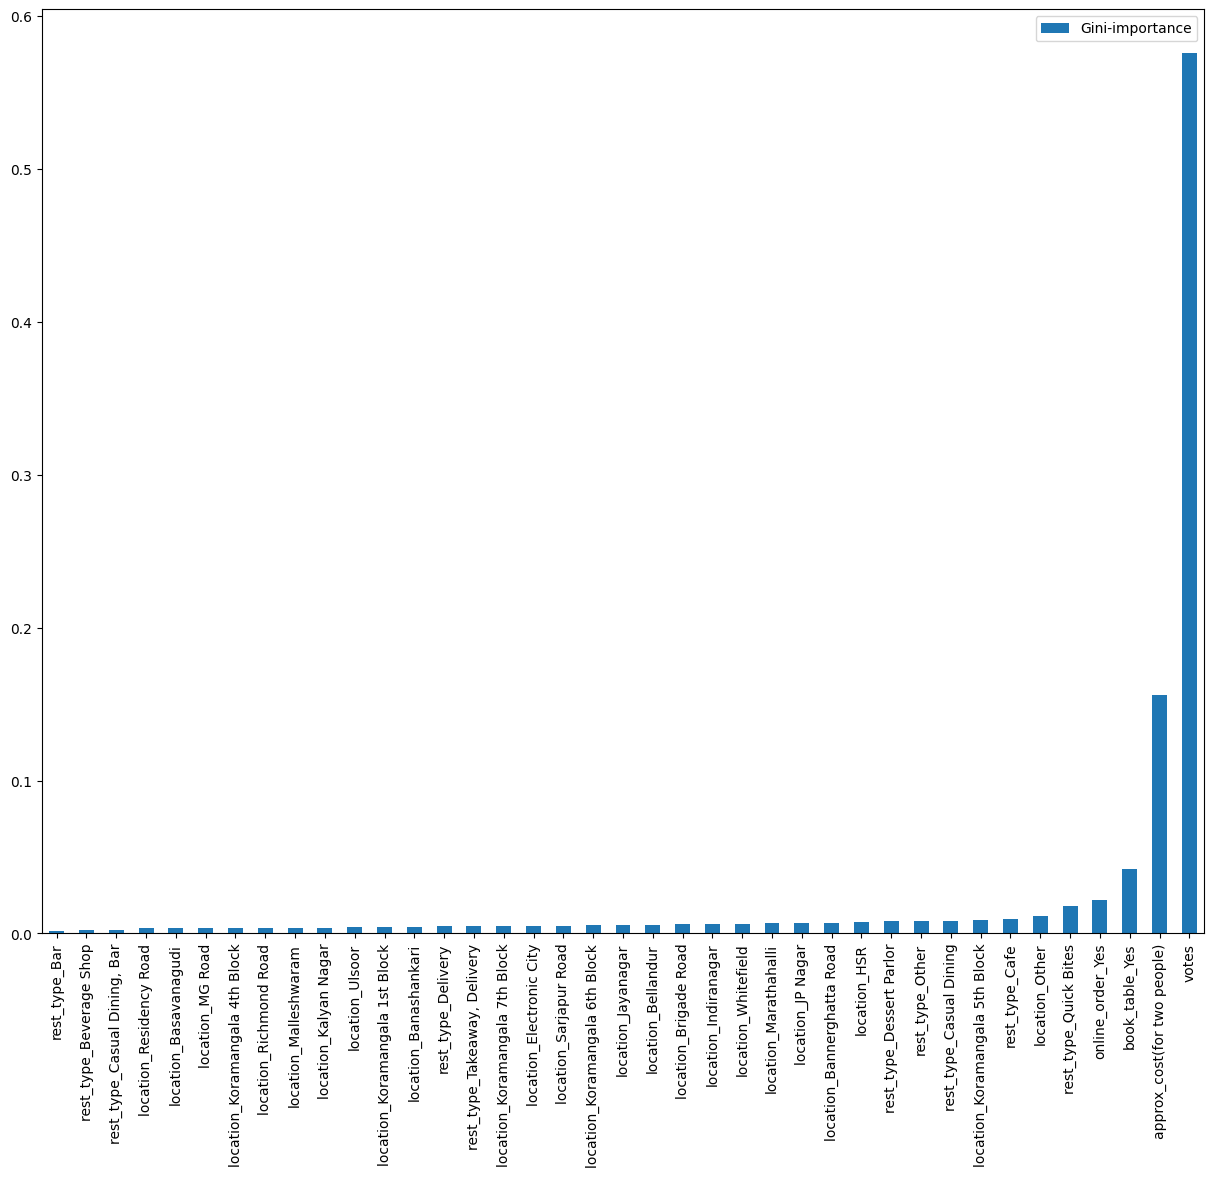

In [37]:
feature_names = [f'feature {i}' for i in range((X.shape[1]))]
forest = RandomForestClassifier(random_state=42)
forest.fit (x_train, y_train)
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X.columns, forest.feature_importances_):
  feats[feature] = importance #add the name/value pair
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values (by='Gini-importance').plot(kind='bar', rot=90, figsize= (15,12))
plt.show()

In [38]:
sclr = StandardScaler()
x_train[x_train.columns] = sclr.fit_transform(x_train[x_train.columns])
x_test[x_test.columns] = sclr.transform(x_test[x_test.columns])

In [39]:
models = {
    'LinearRegression' : LogisticRegression(max_iter=1000) ,
    'KNN' : KNeighborsClassifier(),
    'DecisionTree' : DecisionTreeClassifier(),
    'RandomForest' : RandomForestClassifier(max_depth=10),
    'XGB' : XGBClassifier(),
    'AdaBoost' : AdaBoostClassifier(),
  #  'CatBoost' : CatBoostRegressor()
}


data = {

        'full_dataset' : X.columns ,
        '40_features' : importances.sort_values(by='Gini-importance')[-40:].index.tolist() ,
        '20_features' : importances.sort_values(by='Gini-importance')[-20:].index.tolist() ,
        '10_features' : importances.sort_values(by='Gini-importance')[-10:].index.tolist()
}

In [40]:
for feature_names , feature in data.items():
  train_score = []
  test_score = []
  Classifier = []
  for model_name , model in models.items() :
    #print(f'training with {feature_names}')
    scores = cross_validate(estimator=model , X=X[feature], y=y , cv=StratifiedKFold(n_splits=5),scoring='f1',return_train_score=True)
    #print(f'Train r2 score is : {r2_score(y_train , train)}')
    #print(f'Test r2 score is : {r2_score(y_test , test)}')
    Classifier.append(model_name)
    train_score.append(scores['train_score'].mean())
    test_score.append(scores['test_score'].mean())
  print(f'training with {feature_names} results: ')

  #print(Regressor)
  #print(train_score)
  #print(test_score)
  final = pd.DataFrame({
      'Model' : Classifier ,
      'f1_train' : train_score ,
      'f1_test' : test_score
    })

  display(final)
  print('*' * 50)

training with full_dataset results: 


,Model,f1_train,f1_test
0,LinearRegression,0.783881,0.780281
1,KNN,0.943502,0.884340
2,DecisionTree,0.990731,0.925560
3,RandomForest,0.857393,0.849174
4,XGB,0.915222,0.884802
5,AdaBoost,0.838218,0.836234


**************************************************
training with 40_features results: 


,Model,f1_train,f1_test
0,LinearRegression,0.784041,0.780323
1,KNN,0.943502,0.884340
2,DecisionTree,0.990731,0.925506
3,RandomForest,0.857299,0.849813
4,XGB,0.915616,0.884582
5,AdaBoost,0.838218,0.836234


**************************************************
training with 20_features results: 


,Model,f1_train,f1_test
0,LinearRegression,0.778283,0.777618
1,KNN,0.938676,0.880174
2,DecisionTree,0.984160,0.918705
3,RandomForest,0.865315,0.855424
4,XGB,0.906267,0.877036
5,AdaBoost,0.835383,0.833761


**************************************************
training with 10_features results: 


,Model,f1_train,f1_test
0,LinearRegression,0.774408,0.773404
1,KNN,0.928657,0.873610
2,DecisionTree,0.967425,0.896657
3,RandomForest,0.866602,0.855729
4,XGB,0.894850,0.867190
5,AdaBoost,0.836072,0.834415


**************************************************


# 2nd Trial

In [41]:
df2 = pd.read_csv('zomato.csv')

In [57]:
df2.drop(['url','address','name','phone','dish_liked','reviews_list','menu_item','listed_in(type)','listed_in(city)','cuisines'],axis=1,inplace=True)

In [46]:
def fix_rate(input_rate) :
    if isinstance(input_rate,str) :
        if '/' in input_rate :
            return float(input_rate.split('/')[0].strip())
        else:
            return np.nan
    return np.nan

df2['rate'] = df2['rate'].apply(fix_rate)

In [47]:
knn = KNNImputer(n_neighbors=3)
df2['rate'] = knn.fit_transform(df2[['rate']])

In [48]:
df2.rate.unique()

array([4.1       , 3.8       , 3.7       , 3.6       , 4.6       ,
       4.        , 4.2       , 3.9       , 3.1       , 3.        ,
       3.2       , 3.3       , 2.8       , 4.4       , 4.3       ,
       3.70044882, 2.9       , 3.5       , 2.6       , 3.4       ,
       4.5       , 2.5       , 2.7       , 4.7       , 2.4       ,
       2.2       , 2.3       , 4.8       , 4.9       , 2.1       ,
       2.        , 1.8       ])

In [51]:
def fix_cost(input_cost):
    if isinstance(input_cost,str) :
        return int(input_cost.replace(',',''))
    return input_cost

df2['approx_cost(for two people)'] = df2['approx_cost(for two people)'].apply(fix_cost)

In [54]:
df2['approx_cost(for two people)'].fillna(df2['approx_cost(for two people)'].median() , inplace=True)

In [56]:
df2['rest_type'].fillna(df2['rest_type'].mode().iloc[0] , inplace=True)
df2['location'].fillna(df2['location'].mode().iloc[0] , inplace=True)

In [58]:
df2['location'] = df2['location'].apply(lambda x : x if x in location_list else 'Other')
df2['rest_type'] = df2['rest_type'].apply(lambda x : x if x in rest_type_list else 'Other')

In [60]:
null_votes_idx = df2[df2['votes'] == 0].index
df2.loc[null_votes_idx,'votes'] = np.nan

In [61]:
df2['votes'].fillna(df2['votes'].median() , inplace=True)

In [63]:
ohe = OneHotEncoder(sparse_output=False , drop='first')
ohe_df = pd.DataFrame(ohe.fit_transform(df2[['online_order' , 'book_table' , 'location' , 'rest_type']]),columns=ohe.get_feature_names_out())
ohe_df

,online_order_Yes,book_table_Yes,location_Banashankari,location_Bannerghatta Road,location_Basavanagudi,location_Bellandur,location_Brigade Road,location_Electronic City,location_HSR,location_Indiranagar,...,rest_type_Bar,rest_type_Beverage Shop,rest_type_Cafe,rest_type_Casual Dining,"rest_type_Casual Dining, Bar",rest_type_Delivery,rest_type_Dessert Parlor,rest_type_Other,rest_type_Quick Bites,"rest_type_Takeaway, Delivery"
0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51712,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
51713,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
51714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
51715,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [65]:
df2 = pd.concat([df2 , ohe_df] , axis=1)
df2

,online_order,book_table,rate,votes,location,rest_type,approx_cost(for two people),online_order_Yes,book_table_Yes,location_Banashankari,...,rest_type_Bar,rest_type_Beverage Shop,rest_type_Cafe,rest_type_Casual Dining,"rest_type_Casual Dining, Bar",rest_type_Delivery,rest_type_Dessert Parlor,rest_type_Other,rest_type_Quick Bites,"rest_type_Takeaway, Delivery"
0,Yes,Yes,4.100000,775.0,Banashankari,Casual Dining,800.0,1.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Yes,No,4.100000,787.0,Banashankari,Casual Dining,800.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Yes,No,3.800000,918.0,Banashankari,Other,800.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,No,No,3.700000,88.0,Banashankari,Quick Bites,300.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,No,No,3.800000,166.0,Basavanagudi,Casual Dining,600.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51712,No,No,3.600000,27.0,Whitefield,Bar,1500.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
51713,No,No,3.700449,73.0,Whitefield,Bar,600.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
51714,No,No,3.700449,73.0,Whitefield,Bar,2000.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
51715,No,Yes,4.300000,236.0,Other,Bar,2500.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [66]:
df2.drop(['online_order' , 'book_table' , 'location' , 'rest_type'],axis=1,inplace=True)

In [91]:
df2['rate'] = df2['rate'].apply(lambda x : 1 if x >= 3.7 else 0)

In [92]:
X = df2.drop(['rate'],axis=1)
y = df2['rate']

In [93]:
y

0        1
1        1
2        1
3        1
4        1
        ..
51712    0
51713    1
51714    1
51715    1
51716    0
Name: rate, Length: 51717, dtype: int64

In [94]:
x_train , x_test , y_train , y_test = train_test_split(X , y ,stratify=y, test_size = 0.2 , random_state=0)

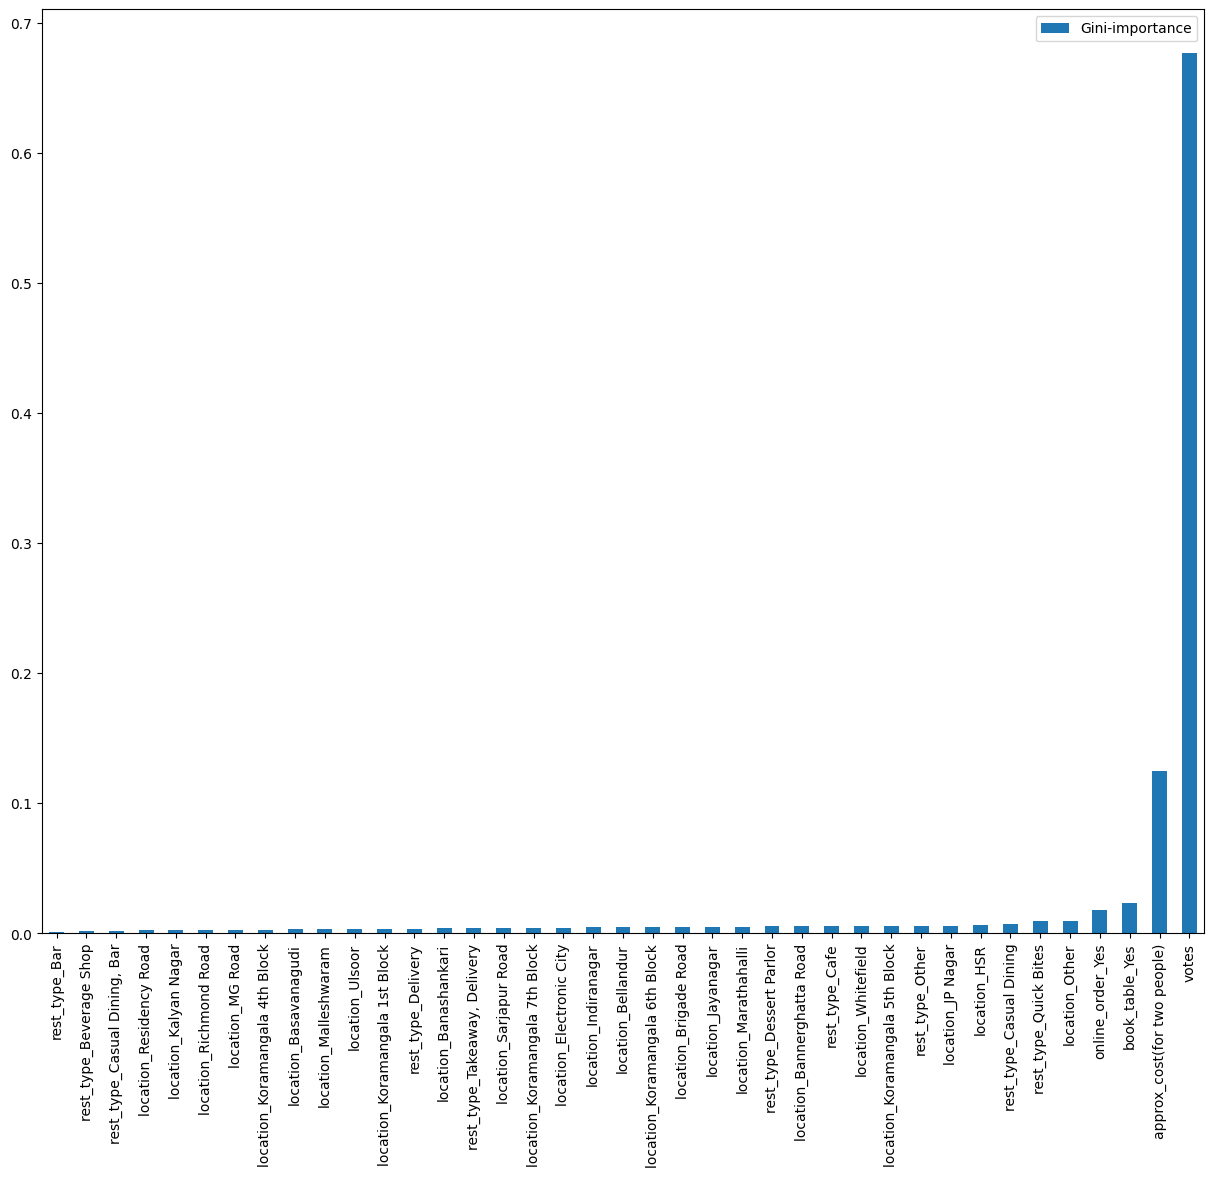

In [95]:
feature_names = [f'feature {i}' for i in range((X.shape[1]))]
forest = RandomForestClassifier(random_state=42)
forest.fit (x_train, y_train)
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X.columns, forest.feature_importances_):
  feats[feature] = importance #add the name/value pair
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values (by='Gini-importance').plot(kind='bar', rot=90, figsize= (15,12))
plt.show()

In [96]:
sclr = StandardScaler()
x_train[x_train.columns] = sclr.fit_transform(x_train[x_train.columns])
x_test[x_test.columns] = sclr.transform(x_test[x_test.columns])

In [97]:
models = {
    'LinearRegression' : LogisticRegression(max_iter=1000) ,
    'KNN' : KNeighborsClassifier(),
    'DecisionTree' : DecisionTreeClassifier(),
    'RandomForest' : RandomForestClassifier(max_depth=10),
    'XGB' : XGBClassifier(),
    'AdaBoost' : AdaBoostClassifier(),
  #  'CatBoost' : CatBoostRegressor()
}


data = {

        'full_dataset' : X.columns ,
        '40_features' : importances.sort_values(by='Gini-importance')[-40:].index.tolist() ,
        '20_features' : importances.sort_values(by='Gini-importance')[-20:].index.tolist() ,
        '10_features' : importances.sort_values(by='Gini-importance')[-10:].index.tolist()
}

In [98]:

for feature_names , feature in data.items():
  train_score = []
  test_score = []
  Classifier = []
  for model_name , model in models.items() :
    #print(f'training with {feature_names}')
    scores = cross_validate(estimator=model , X=X[feature], y=y , cv=StratifiedKFold(n_splits=5),scoring='f1',return_train_score=True)
    #print(f'Train r2 score is : {r2_score(y_train , train)}')
    #print(f'Test r2 score is : {r2_score(y_test , test)}')
    Classifier.append(model_name)
    train_score.append(scores['train_score'].mean())
    test_score.append(scores['test_score'].mean())
  print(f'training with {feature_names} results: ')

  #print(Regressor)
  #print(train_score)
  #print(test_score)
  final = pd.DataFrame({
      'Model' : Classifier ,
      'f1_train' : train_score ,
      'f1_test' : test_score
    })

  display(final)
  print('*' * 50)

training with full_dataset results: 


,Model,f1_train,f1_test
0,LinearRegression,0.840871,0.835784
1,KNN,0.959821,0.917484
2,DecisionTree,0.992734,0.947902
3,RandomForest,0.893786,0.889443
4,XGB,0.939182,0.917568
5,AdaBoost,0.882425,0.880729


**************************************************
training with 40_features results: 


,Model,f1_train,f1_test
0,LinearRegression,0.839433,0.835798
1,KNN,0.959821,0.917484
2,DecisionTree,0.992734,0.947327
3,RandomForest,0.893353,0.889202
4,XGB,0.939413,0.918423
5,AdaBoost,0.882425,0.880729


**************************************************
training with 20_features results: 


,Model,f1_train,f1_test
0,LinearRegression,0.841285,0.838377
1,KNN,0.955639,0.914349
2,DecisionTree,0.987089,0.938864
3,RandomForest,0.900185,0.894123
4,XGB,0.932060,0.912851
5,AdaBoost,0.880535,0.879166


**************************************************
training with 10_features results: 


,Model,f1_train,f1_test
0,LinearRegression,0.843841,0.842964
1,KNN,0.949305,0.908894
2,DecisionTree,0.977420,0.928665
3,RandomForest,0.904077,0.895313
4,XGB,0.925645,0.904463
5,AdaBoost,0.879621,0.878982


**************************************************


# optuna

In [99]:
df3 = pd.read_csv('zomato.csv')

In [100]:
df3.drop(['url','address','name','phone','dish_liked','reviews_list','menu_item','listed_in(type)','listed_in(city)','cuisines'],axis=1,inplace=True)

In [101]:
def fix_rate(input_rate) :
    if isinstance(input_rate,str) :
        if '/' in input_rate :
            return float(input_rate.split('/')[0].strip())
        else:
            return np.nan
    return np.nan

df3['rate'] = df3['rate'].apply(fix_rate)

In [102]:
# Apply KNN Imputer for target column:
knn = KNNImputer(n_neighbors=3)
df3['rate'] = knn.fit_transform(df3[['rate']])

In [103]:
df3['rate'] = df3['rate'].apply(lambda x : 1 if x >= 3.7 else 0)

In [104]:
null_votes_idx = df3[df3['votes'] == 0].index
df3.loc[null_votes_idx,'votes'] = np.nan

In [105]:
def fix_cost(input_cost):
    if isinstance(input_cost,str) :
        return int(input_cost.replace(',',''))
    return input_cost

df3['approx_cost(for two people)'] = df3['approx_cost(for two people)'].apply(fix_cost)

In [106]:
df3['location'] = df3['location'].apply(lambda x : x if x in location_list else 'Other')
df3['rest_type'] = df3['rest_type'].apply(lambda x : x if x in rest_type_list else 'Other')

In [108]:
numerical = KNNImputer(n_neighbors=3)
categorial = Pipeline(steps=[
    ('imputer' , SimpleImputer(strategy='most_frequent')),
    ('ohe' , OneHotEncoder(sparse_output=False , drop='first'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num' , numerical , ['votes' , 'approx_cost(for two people)']),
    ('cat' , categorial , ['online_order' , 'book_table' , 'location' , 'rest_type'])
] , verbose_feature_names_out=False , remainder='passthrough')


my_pipe = Pipeline(steps=[
    ('process' , preprocessor)
])
pd.DataFrame(my_pipe.fit_transform(df3) , columns=my_pipe[0].get_feature_names_out())

,votes,approx_cost(for two people),online_order_Yes,book_table_Yes,location_Banashankari,location_Bannerghatta Road,location_Basavanagudi,location_Bellandur,location_Brigade Road,location_Electronic City,...,rest_type_Beverage Shop,rest_type_Cafe,rest_type_Casual Dining,"rest_type_Casual Dining, Bar",rest_type_Delivery,rest_type_Dessert Parlor,rest_type_Other,rest_type_Quick Bites,"rest_type_Takeaway, Delivery",rate
0,775.000000,800.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,787.000000,800.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,918.000000,800.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,88.000000,300.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,166.000000,600.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51712,27.000000,1500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
51713,1002.666667,600.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
51714,196.000000,2000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
51715,236.000000,2500.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [141]:
models = {

    'DecisionTree' : DecisionTreeClassifier,
    'RandomForest' : RandomForestClassifier,
    'XGB' :XGBClassifier,
    
}
def objective(trial)  :

  X , y = df3.drop('rate',axis=1) , df3['rate']
  param = get_params(trial)
  print(Model(**param))


  model = Pipeline(steps=[

          ('process' , preprocessor),
          ('sclr' , StandardScaler()),
          (model_name , Model(**param))
      ])



  scores = cross_val_score(model,X,y,cv=StratifiedKFold(5) , scoring = 'f1')

  return scores.mean()


def get_params(trial) :

  params = {


       
          'DecisionTree'     : {
                                  'max_depth' : trial.suggest_int('max_depth',5,50),
                                 'splitter'  : choice(['best' , 'random']),
                                  'max_features' : trial.suggest_uniform('max_features' ,0 ,1)
                              },
         'RandomForest'     : {
                                  'max_depth' : trial.suggest_int('max_depth' , 5 , 50),
                                  'n_estimators' : trial.suggest_int('n_estimators' , 50 , 300),
                                  'max_features' : trial.suggest_uniform('max_features',0,1),
                                  'min_samples_split' : trial.suggest_int('min_samples_split',2,4),
                                  'bootstrap' : trial.suggest_categorical('bootstrap' , [True,False])
                                },
          'XGB'              : {
                                  'max_depth' : trial.suggest_int('max_depth' , 10 , 40),
                                  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
                                  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
                                  'colsample_bynode' : trial.suggest_uniform('colsample_bynode' ,0,1),
                                 # 'subsample' : trial.suggest_uniform('subsample',0.01 , 1),
                                  'eta' : trial.suggest_uniform('eta',0,1),
                                  'lambda' : trial.suggest_int('lambda',0,1000),
                                  'alpha' : trial.suggest_int('alpha',0,1000),
                                  'gamma' : trial.suggest_int('gamma' ,0 , 1000),
                                  'n_estimators': trial.suggest_int('n_estimators',50,500),
                                  'learning_rate' : trial.suggest_float('learning_rate',1,10)
                                }
          
        }

  return params[model_name]




modelname = []
best_estimator = []


for model_name , Model in models.items() :




  study = optuna.create_study(study_name= model_name , direction='maximize')
  study.optimize(objective, n_trials=10)
  modelname.append(model_name)
 
  best_estimator.append(Pipeline(steps=[

          ('process' , preprocessor),
          ('sclr' , StandardScaler()),
          (model_name , Model(**study.best_params))
      ])
)
  


[I 2023-12-22 17:44:09,406] A new study created in memory with name: XGB
C:\Users\rider\AppData\Local\Temp\ipykernel_14856\166343048.py:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
C:\Users\rider\AppData\Local\Temp\ipykernel_14856\166343048.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0,1),
C:\Users\rider\AppData\Local\Temp\ipykernel_14856\166343048.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bynode

XGBClassifier(alpha=554, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.4790326654782572,
              colsample_bynode=0.18017328355818318,
              colsample_bytree=0.18506411422773805, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eta=0.01885030057783521, eval_metric=None, feature_types=None,
              gamma=601, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=662,
              learning_rate=4.298344953429723, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=28, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=267, ...)


[I 2023-12-22 17:46:04,788] Trial 0 finished with value: 0.47697565105994755 and parameters: {'max_depth': 28, 'colsample_bytree': 0.18506411422773805, 'colsample_bylevel': 0.4790326654782572, 'colsample_bynode': 0.18017328355818318, 'eta': 0.01885030057783521, 'lambda': 662, 'alpha': 554, 'gamma': 601, 'n_estimators': 267, 'learning_rate': 4.298344953429723}. Best is trial 0 with value: 0.47697565105994755.
C:\Users\rider\AppData\Local\Temp\ipykernel_14856\166343048.py:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
C:\Users\rider\AppData\Local\Temp\ipykernel_14856\166343048.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'col

XGBClassifier(alpha=25, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.25106376115600193,
              colsample_bynode=0.769244738439853,
              colsample_bytree=0.050849421295532715, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eta=0.6824385943592522, eval_metric=None, feature_types=None,
              gamma=467, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=975,
              learning_rate=2.330781828185508, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=30, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=324, ...)


[I 2023-12-22 17:47:58,372] Trial 1 finished with value: 0.49053992908450567 and parameters: {'max_depth': 30, 'colsample_bytree': 0.050849421295532715, 'colsample_bylevel': 0.25106376115600193, 'colsample_bynode': 0.769244738439853, 'eta': 0.6824385943592522, 'lambda': 975, 'alpha': 25, 'gamma': 467, 'n_estimators': 324, 'learning_rate': 2.330781828185508}. Best is trial 1 with value: 0.49053992908450567.
C:\Users\rider\AppData\Local\Temp\ipykernel_14856\166343048.py:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
C:\Users\rider\AppData\Local\Temp\ipykernel_14856\166343048.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsa

XGBClassifier(alpha=456, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.47299119080819263,
              colsample_bynode=0.9728176823788572,
              colsample_bytree=0.9852335309956126, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eta=0.8166782370521725, eval_metric=None, feature_types=None,
              gamma=231, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=466,
              learning_rate=1.1531280818188452, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=35, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, ...)


[I 2023-12-22 17:49:48,859] Trial 2 finished with value: 0.8630633528063019 and parameters: {'max_depth': 35, 'colsample_bytree': 0.9852335309956126, 'colsample_bylevel': 0.47299119080819263, 'colsample_bynode': 0.9728176823788572, 'eta': 0.8166782370521725, 'lambda': 466, 'alpha': 456, 'gamma': 231, 'n_estimators': 300, 'learning_rate': 1.1531280818188452}. Best is trial 2 with value: 0.8630633528063019.
C:\Users\rider\AppData\Local\Temp\ipykernel_14856\166343048.py:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
C:\Users\rider\AppData\Local\Temp\ipykernel_14856\166343048.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsam

XGBClassifier(alpha=368, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.26512241253406854,
              colsample_bynode=0.5118965749696778,
              colsample_bytree=0.24264449087428863, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eta=0.37987396537504325, eval_metric=None, feature_types=None,
              gamma=589, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=834,
              learning_rate=8.06537042576552, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=29, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=71, ...)


[I 2023-12-22 17:51:37,428] Trial 3 finished with value: 0.0 and parameters: {'max_depth': 29, 'colsample_bytree': 0.24264449087428863, 'colsample_bylevel': 0.26512241253406854, 'colsample_bynode': 0.5118965749696778, 'eta': 0.37987396537504325, 'lambda': 834, 'alpha': 368, 'gamma': 589, 'n_estimators': 71, 'learning_rate': 8.06537042576552}. Best is trial 2 with value: 0.8630633528063019.
C:\Users\rider\AppData\Local\Temp\ipykernel_14856\166343048.py:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
C:\Users\rider\AppData\Local\Temp\ipykernel_14856\166343048.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : t

XGBClassifier(alpha=67, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.9732963453859281,
              colsample_bynode=0.9293718299844905,
              colsample_bytree=0.030737591111212437, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eta=0.47524816536028325, eval_metric=None, feature_types=None,
              gamma=539, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=654,
              learning_rate=7.248355353262069, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=23, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=321, ...)


[I 2023-12-22 17:53:30,247] Trial 4 finished with value: 0.0 and parameters: {'max_depth': 23, 'colsample_bytree': 0.030737591111212437, 'colsample_bylevel': 0.9732963453859281, 'colsample_bynode': 0.9293718299844905, 'eta': 0.47524816536028325, 'lambda': 654, 'alpha': 67, 'gamma': 539, 'n_estimators': 321, 'learning_rate': 7.248355353262069}. Best is trial 2 with value: 0.8630633528063019.
C:\Users\rider\AppData\Local\Temp\ipykernel_14856\166343048.py:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
C:\Users\rider\AppData\Local\Temp\ipykernel_14856\166343048.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : 

XGBClassifier(alpha=119, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.9515446160579062,
              colsample_bynode=0.5377947224938854,
              colsample_bytree=0.2786109073164055, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eta=0.8959186918360701, eval_metric=None, feature_types=None,
              gamma=906, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=601,
              learning_rate=3.1417175663885235, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=34, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=318, ...)


[I 2023-12-22 17:55:20,641] Trial 5 finished with value: 0.6359643496501841 and parameters: {'max_depth': 34, 'colsample_bytree': 0.2786109073164055, 'colsample_bylevel': 0.9515446160579062, 'colsample_bynode': 0.5377947224938854, 'eta': 0.8959186918360701, 'lambda': 601, 'alpha': 119, 'gamma': 906, 'n_estimators': 318, 'learning_rate': 3.1417175663885235}. Best is trial 2 with value: 0.8630633528063019.
C:\Users\rider\AppData\Local\Temp\ipykernel_14856\166343048.py:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
C:\Users\rider\AppData\Local\Temp\ipykernel_14856\166343048.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsamp

XGBClassifier(alpha=123, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.5354231856818534,
              colsample_bynode=0.7032674982543562,
              colsample_bytree=0.023526770867224878, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eta=0.46755049514104763, eval_metric=None, feature_types=None,
              gamma=717, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=225,
              learning_rate=2.3574251311589105, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=33, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=442, ...)


[I 2023-12-22 17:57:11,451] Trial 6 finished with value: 0.31798217482509206 and parameters: {'max_depth': 33, 'colsample_bytree': 0.023526770867224878, 'colsample_bylevel': 0.5354231856818534, 'colsample_bynode': 0.7032674982543562, 'eta': 0.46755049514104763, 'lambda': 225, 'alpha': 123, 'gamma': 717, 'n_estimators': 442, 'learning_rate': 2.3574251311589105}. Best is trial 2 with value: 0.8630633528063019.
C:\Users\rider\AppData\Local\Temp\ipykernel_14856\166343048.py:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
C:\Users\rider\AppData\Local\Temp\ipykernel_14856\166343048.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'col

XGBClassifier(alpha=17, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.30951096388327937,
              colsample_bynode=0.3067138023819528,
              colsample_bytree=0.1901933437376384, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eta=0.2704534277871876, eval_metric=None, feature_types=None,
              gamma=717, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=80,
              learning_rate=2.434580545892671, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=29, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=236, ...)


[I 2023-12-22 17:59:02,042] Trial 7 finished with value: 0.0 and parameters: {'max_depth': 29, 'colsample_bytree': 0.1901933437376384, 'colsample_bylevel': 0.30951096388327937, 'colsample_bynode': 0.3067138023819528, 'eta': 0.2704534277871876, 'lambda': 80, 'alpha': 17, 'gamma': 717, 'n_estimators': 236, 'learning_rate': 2.434580545892671}. Best is trial 2 with value: 0.8630633528063019.
C:\Users\rider\AppData\Local\Temp\ipykernel_14856\166343048.py:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
C:\Users\rider\AppData\Local\Temp\ipykernel_14856\166343048.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel' : tri

XGBClassifier(alpha=106, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.5202580921446911,
              colsample_bynode=0.6985507088525942,
              colsample_bytree=0.5747778383074986, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eta=0.5968221856835108, eval_metric=None, feature_types=None,
              gamma=236, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=251,
              learning_rate=2.272416632085718, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=36, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=63, ...)


[I 2023-12-22 18:00:50,251] Trial 8 finished with value: 0.3230087694284892 and parameters: {'max_depth': 36, 'colsample_bytree': 0.5747778383074986, 'colsample_bylevel': 0.5202580921446911, 'colsample_bynode': 0.6985507088525942, 'eta': 0.5968221856835108, 'lambda': 251, 'alpha': 106, 'gamma': 236, 'n_estimators': 63, 'learning_rate': 2.272416632085718}. Best is trial 2 with value: 0.8630633528063019.
C:\Users\rider\AppData\Local\Temp\ipykernel_14856\166343048.py:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1),
C:\Users\rider\AppData\Local\Temp\ipykernel_14856\166343048.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample

XGBClassifier(alpha=250, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.6458703524161891,
              colsample_bynode=0.4817765318697409,
              colsample_bytree=0.9916754095970144, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eta=0.12391521399534688, eval_metric=None, feature_types=None,
              gamma=714, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=426,
              learning_rate=2.2046278846941236, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=18, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=311, ...)


[I 2023-12-22 18:02:39,596] Trial 9 finished with value: 0.6624052646575136 and parameters: {'max_depth': 18, 'colsample_bytree': 0.9916754095970144, 'colsample_bylevel': 0.6458703524161891, 'colsample_bynode': 0.4817765318697409, 'eta': 0.12391521399534688, 'lambda': 426, 'alpha': 250, 'gamma': 714, 'n_estimators': 311, 'learning_rate': 2.2046278846941236}. Best is trial 2 with value: 0.8630633528063019.


In [142]:
study.best_params

{'max_depth': 35,
 'colsample_bytree': 0.9852335309956126,
 'colsample_bylevel': 0.47299119080819263,
 'colsample_bynode': 0.9728176823788572,
 'eta': 0.8166782370521725,
 'lambda': 466,
 'alpha': 456,
 'gamma': 231,
 'n_estimators': 300,
 'learning_rate': 1.1531280818188452}

In [147]:
best_estimator

[Pipeline(steps=[('process',
                  ColumnTransformer(remainder='passthrough',
                                    transformers=[('num',
                                                   KNNImputer(n_neighbors=3),
                                                   ['votes',
                                                    'approx_cost(for two '
                                                    'people)']),
                                                  ('cat',
                                                   Pipeline(steps=[('imputer',
                                                                    SimpleImputer(strategy='most_frequent')),
                                                                   ('ohe',
                                                                    OneHotEncoder(drop='first',
                                                                                  sparse_output=False))]),
                                                

In [149]:
model_name = ['RandomForest' , 'DecisionTree' , 'XGB']

In [157]:
#scores
X , y = df3.drop('rate' , axis=1) , df3['rate']
for name , model in zip(model_name , best_estimator) :
    print(name)
    score = cross_val_score(model , X , y , cv = StratifiedKFold(5) , scoring='f1')
    print(score.mean())

RandomForest
0.9559976765643462
DecisionTree
0.9482832601766411
XGB
0.8630633528063019


In [158]:
import joblib
joblib.dump(best_estimator[0] , 'zomato_rf.pkl')
joblib.dump(best_estimator[0] , 'zomato_rf.h5')

['zomato_rf.h5']